<a href="https://colab.research.google.com/github/danjohnvelasco/Filipino-ULMFiT/blob/master/Filipino_ULMFiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Filipino ULMFiT
This notebook shows the ULMFiT approach to Filipino text classification task on [Hate Speech Dataset](https://github.com/jcblaisecruz02/Filipino-Text-Benchmarks#datasets) using a pre-trained Filipino language model. To learn more about the ULMFiT approach check the [Docs](https://docs.fast.ai/tutorial.text) and [Paper](https://arxiv.org/abs/1801.06146).

If you wish to apply this on another text classification dataset, you may do so.
It's just a matter of replacing the dataset in the code.

Originally posted in this [repository](https://github.com/danjohnvelasco/Filipino-ULMFiT).

In [ ]:
# Install fastai v2
# uncomment if your environment doesn't use fastai >= v2.
# run pip freeze to check if fastai is installed

# !pip install -U fastai

In [1]:
# if you're on Colab, make sure you're using a GPU instance.
# Make sure that your GPU supports mixed-precisoin traning (e.g. Tesla T4, P4, P100, V100)
!nvidia-smi

Thu Oct 15 03:45:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# if you're on Colab, and what to save files in Google Drive:
#from google.colab import drive
#drive.mount('/gdrive')
#%cd "/gdrive/My Drive/"

# Download pre-trained language model

In [ ]:
# create 'models' folder
!mkdir models

# download pre-trained model and language model vocab (size: 432MB)
!gdown --id 19jdv8-XEbDNiqlm_lPb1csbVZYkn3gfA

# unzip the pre-trained model
!unzip pretrained.zip -d models

In [29]:
# Filenames of pre-trained LM weights and vocab
# To be passed to text_classifier_learner() later on
pretrained_fnames = ['finetuned_weights_20', 'vocab']

## Download Text Classification Dataset

In [ ]:
!wget https://s3.us-east-2.amazonaws.com/blaisecruz.com/datasets/hatenonhate/hatespeech_raw.zip
!unzip hatespeech_raw.zip

# Before you start...

1.  Import dependencies
2.  Define convenient functions for later use
3.  Load data

In [5]:
from fastai.text.all import *
from sklearn.metrics import accuracy_score

In [6]:
# Run this function before creating a learner if you want  
# your work to be reproducible

# Convenience function for setting the random seed manually
def set_random_seed(seed):
    # python RNG
    import random
    random.seed(seed)

    # pytorch RNGs
    import torch
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

    # numpy RNG
    import numpy as np
    np.random.seed(seed)

In [7]:
# Convenience function for testing model on test set
def get_test_acc(learn):
    # Create dataloader for test set
    test_dl = learn.dls.test_dl(test_df, with_label=True)
    # Make predictions on test set
    pred_probas, _ , pred_classes = learn.get_preds(dl=test_dl, with_decoded=True) 
    # get accuracy of (y_true, y_pred)
    return accuracy_score(test_df.label.values, pred_classes)

In [31]:
# Modify this to match your data directory
train_df = pd.read_csv("hatespeech/train.csv", lineterminator='\n')
valid_df = pd.read_csv("hatespeech/valid.csv", lineterminator='\n')
test_df = pd.read_csv("hatespeech/test.csv", lineterminator='\n')

In [32]:
# add 'is_valid' column (for fastai train-val splitting)
valid_df['is_valid'] = True
test_df['is_valid'] = False
train_df['is_valid'] = False

In [33]:
# label: hate = 1, non-hate = 0
train_df.head()

,text,label,is_valid
0,GASTOS NI VP BINAY SA POLITICAL ADS HALOS P7-M NA\r\rInaasahan na ni Vice President Jejomar Binay na may mga taong... https://t.co/SDytgbWiLh,0,False
1,Mar Roxas TANG INA TUWID NA DAAN DAW .. EH SYA NGA DI STRAIGHT,1,False
2,Salamat sa walang sawang suporta ng mga taga makati! Ang Pagbabalik Binay In Makati #OnlyBinayInMakatiSanKaPa https://t.co/iwAOdtZPRE,0,False
3,@rapplerdotcom putangina mo binay TAKBO PA,1,False
4,"Binay with selective amnesia, forgetting about the past six years he spent preparing to be president. #PiliPinasDebates2016",0,False


# Language Model Fine-tuning

Here, we fine-tune the pre-trained language model to better learn the vocab and syntax of the target corpus which is, in our case, the Hate Speech Dataset.

**About the pre-trained language model files:**

By default, fastai looks for models inside the 'models' folder. Make sure that the pre-trained models and vocab are in 'models' folder.

In [17]:
# Concatenate train, validation, and test set for LM fine-tuning
# Language modelling task doesn't need labels so it's safe to use the test set
lm_df_10k =  pd.concat([train_df, valid_df, test_df])
lm_df_10k.shape

(18464, 3)

In [18]:
# Create a dataloader for language model fine-tuning
# ColSplitter() splits the dataframe by 'is_valid' column
dls_lm = DataBlock(blocks=TextBlock.from_df('text', is_lm=True),
                    get_x=ColReader('text'),
                    splitter=ColSplitter()).dataloaders(lm_df_10k, bs=128, seq_len=72, min_freq=2, num_workers=0)

In [63]:
# Uncomment this if you want early stopping and save your best model.
# This is fastai callbacks, see docs for more info
cbs = [EarlyStoppingCallback(monitor='valid_loss', patience=2), SaveModelCallback()]

# Notice the pretrained_fnames parameter.
# Here we pass the list of filenames of pretrained weights and vocab.pkl
# This is where the use of pre-trained language model happens.
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.5, 
    metrics=[accuracy, Perplexity()],
    pretrained_fnames=pretrained_fnames, cbs=cbs).to_fp16()

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=0.0831763744354248)

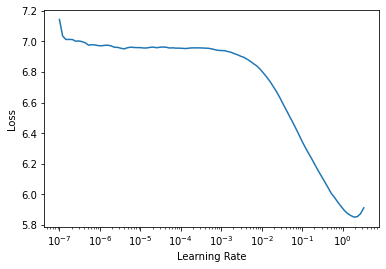

In [64]:
# Learning rate finder
learn.lr_find()

In [65]:
# train last layers first
learn.fit_one_cycle(1, 4e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.713461,4.021697,0.327076,55.795715,00:20


Better model found at epoch 0 with valid_loss value: 4.021697044372559.


In [66]:
# train the whole network with a smaller learning rate
learn.unfreeze()
learn.fit_one_cycle(8, 4e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.942059,3.778240,0.353193,43.738991,00:21
1,3.783178,3.586052,0.377635,36.091293,00:20
2,3.586731,3.460168,0.392891,31.822311,00:20
3,3.407196,3.393142,0.403265,29.759310,00:20
4,3.252400,3.363641,0.408120,28.894197,00:20
5,3.113715,3.356634,0.411461,28.692461,00:21
6,3.002027,3.357580,0.412802,28.719618,00:20
7,2.932654,3.361399,0.412839,28.829493,00:20


Better model found at epoch 0 with valid_loss value: 3.7782399654388428.
Better model found at epoch 1 with valid_loss value: 3.5860517024993896.
Better model found at epoch 2 with valid_loss value: 3.460167646408081.
Better model found at epoch 3 with valid_loss value: 3.393141984939575.
Better model found at epoch 4 with valid_loss value: 3.363640785217285.
Better model found at epoch 5 with valid_loss value: 3.3566343784332275.
No improvement since epoch 5: early stopping


In [67]:
# Save encoder. To be used by text classifier learner.
learn.save_encoder('lm_finetune_final_enc')

In [40]:
# This is totally unrelated to training process but just for fun...
# you can try generating text with the language model here
TEXT = "Ako ay"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

print("\n".join(preds))

Ako ay si Binay ? Maganda pa yung mga ginagawa ni Binay . " Binay Ad Nog Nog ? ? Mahirap ka Binay ! # wantedpresident Duterte ,
Ako ay isang " pandak " sa Makati . Ang nognog yun ? Wtf ? ? Knya suportado ng mga mar roxas sa Marawi Lanao del Sur … Hahahaha Mar Roxas


# Text Classifier Fine-tuning

Here, we use the encoder of the fine-tuned language model to transfer the learnings to the classifier model. The model will learn to classify the text to binary labels, hate (1) or non-hate (0).

Here, we'll apply gradual unfreezing and discriminative learning rates as discussed by [(Howard and Ruder, 2018)](https://arxiv.org/abs/1801.06146).

In [41]:
# HYPERPARAMETERS
lr = 5e-2
wd = 0.1
moms = (0.8,0.7,0.6)

In [52]:
# Exclude the test set
clas_df_10k = pd.concat([train_df, valid_df])
clas_df_10k.shape # 10k + valid set

(14232, 3)

In [53]:
# Create a dataloader for text classifier fine-tuning
dls_clas = DataBlock(blocks=(TextBlock.from_df('text', seq_len=72, min_freq=2, vocab=dls_lm.vocab), CategoryBlock),
                      get_x=ColReader('text'),
                      get_y=ColReader('label'),
                      splitter=ColSplitter()
                      ).dataloaders(clas_df_10k, bs=128, num_workers=0)

In [68]:
# Set random seed manually for reproducibility
set_random_seed(2014614837)

In [69]:
# Create learner
learn = text_classifier_learner(dls_clas, AWD_LSTM, moms=moms, wd=wd, metrics=accuracy).to_fp16()

# Load encoder of fine-tuned language model
learn.load_encoder('lm_finetune_final_enc')

In [70]:
# Train the last layers
learn.fit_one_cycle(4, lr) 

epoch,train_loss,valid_loss,accuracy,time
0,0.696004,0.557743,0.708412,00:19
1,0.672074,0.521690,0.733459,00:19
2,0.654777,0.543808,0.701796,00:19
3,0.636296,0.513312,0.737004,00:19


In [71]:
# Unfreeze a little bit
learn.freeze_to(-2)

# Decrease the learning rate
learn.fit_one_cycle(2, slice(lr/(2.6**4),lr)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.603289,0.529903,0.721881,00:20
1,0.541825,0.498178,0.745983,00:20


In [72]:
# Unfreeze a little bit more
learn.freeze_to(-3)

# Decrease the learning rate more
learn.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.520084,0.484902,0.757089,00:21
1,0.450389,0.478982,0.770085,00:21


In [73]:
# Unfreeze the whole network
learn.unfreeze()

# Train the whole network with really small learning rate
learn.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.381500,0.492208,0.769376,00:22


In [74]:
# Get accuracy with test set
acc = get_test_acc(learn)
acc

0.7573251417769377

Even though the purpose of this notebook is to show you how to use the pre-trained model in text classification tasks, it's worth noting that there's a slight discrepancy in reported accuracy and the accuracy printed in this notebook. In this notebook, we didn't use the same exact encoder which explains the slight difference in results. In this case, seeds used to initialize the model plays a small role in the accuracy. The accuracy ranges from 75 to 76.9% with different seeds.